In [1]:
import tensorflow as tf
import pandas as pd
from utils import *
from tacotron import Tacotron

In [2]:
metadata = pd.read_csv(data+'metadata.csv',sep='|',header=None)
print(metadata.shape)
metadata.head()

(13100, 3)


,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [3]:
paths, lengths, texts = [], [], []
for i in range(metadata.shape[0]):
    paths.append('%swavs/%s.wav'%(data, metadata.iloc[i,0]))
    text = text_normalize(metadata.iloc[i,1]) + "E"
    texts.append(np.array([char2idx[char] for char in text], np.int32))
    lengths.append(len(text))

In [4]:
count_correct = 0
mel_list = [os.path.basename(i)[:-4] for i in os.listdir('mel')]
for i in metadata.iloc[:, 0].tolist():
    if i in mel_list:
        count_correct += 1

if count_correct == metadata.shape[0]:
    print('load from cached')
    get_function = get_cached
else:
    print('load from files')
    get_function = load_file

load from cached


In [ ]:
def dynamic_batching(paths):
    files, max_y, max_z = [], 0, 0
    for n in range(batch_size):
        files.append(get_function(paths[n]))
        if files[-1][1].shape[0] > max_y:
            max_y = files[-1][1].shape[0]
        if files[-1][2].shape[0] > max_z:
            max_z = files[-1][2].shape[0]
    return files, max_y, max_z

minibatch loop:  22%|██▏       | 181/818 [05:58<21:02,  1.98s/it]

(138, 153)


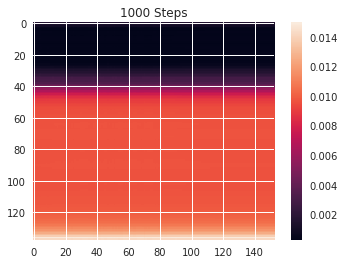

minibatch loop:  44%|████▍     | 363/818 [11:55<14:57,  1.97s/it]

(139, 161)


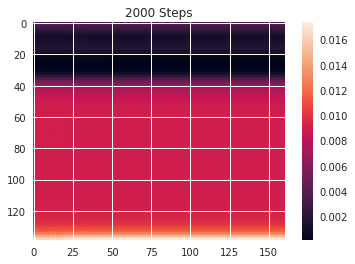

minibatch loop:  67%|██████▋   | 545/818 [17:51<08:56,  1.97s/it]

(153, 160)


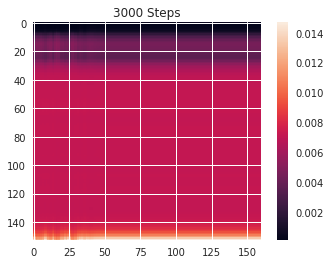

minibatch loop:  89%|████████▉ | 727/818 [23:51<02:59,  1.97s/it]

(163, 159)


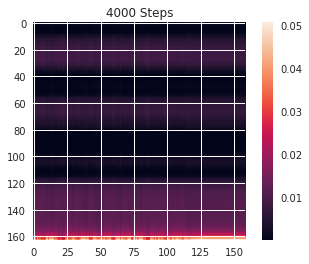

minibatch loop:  11%|█         | 91/818 [03:01<24:12,  2.00s/it]

(160, 162)


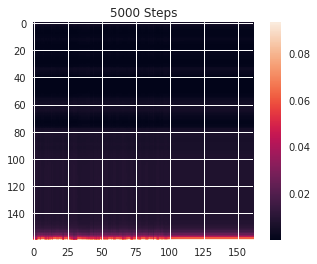

minibatch loop:  33%|███▎      | 273/818 [09:01<18:00,  1.98s/it]

(140, 156)


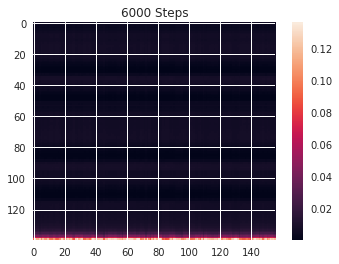

minibatch loop:  56%|█████▌    | 455/818 [14:57<11:56,  1.97s/it]

(154, 159)


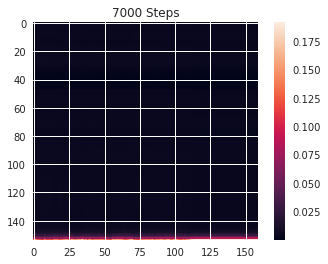

minibatch loop:  78%|███████▊  | 637/818 [20:52<05:55,  1.97s/it]

(132, 156)


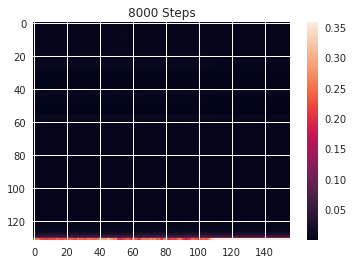

minibatch loop:   0%|          | 1/818 [00:02<27:41,  2.03s/it]

(139, 155)


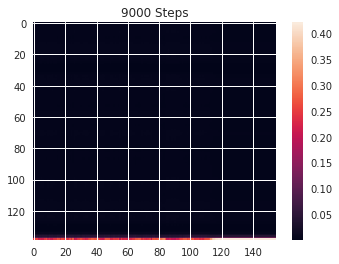

minibatch loop:  22%|██▏       | 183/818 [06:02<20:58,  1.98s/it]

(164, 162)


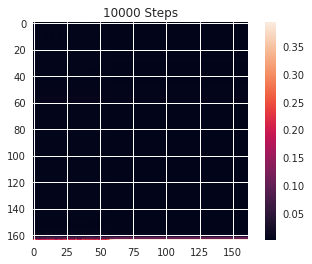

minibatch loop:  45%|████▍     | 365/818 [12:02<14:57,  1.98s/it]

(108, 116)


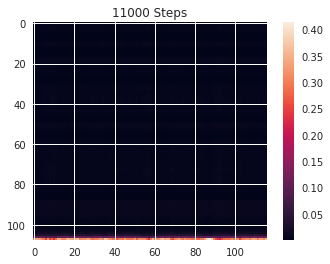

minibatch loop:  67%|██████▋   | 547/818 [17:54<08:52,  1.96s/it]

(183, 162)


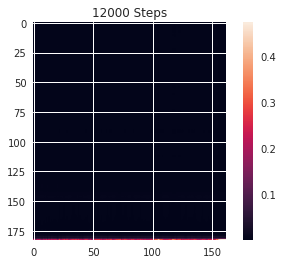

minibatch loop:  89%|████████▉ | 729/818 [23:54<02:55,  1.97s/it]

(142, 150)


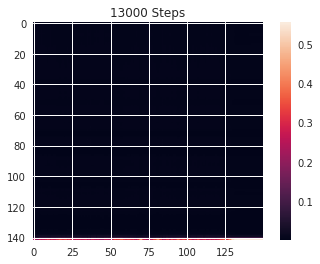

minibatch loop:  11%|█▏        | 93/818 [03:03<23:53,  1.98s/it]

(159, 155)


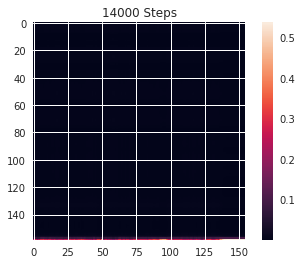

minibatch loop:  34%|███▎      | 275/818 [09:02<17:51,  1.97s/it]

(133, 161)


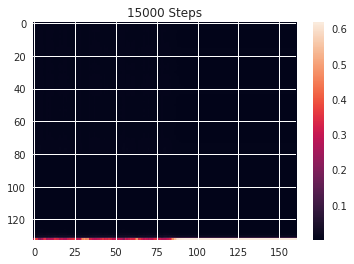

minibatch loop:  56%|█████▌    | 457/818 [14:57<11:49,  1.96s/it]

(121, 149)


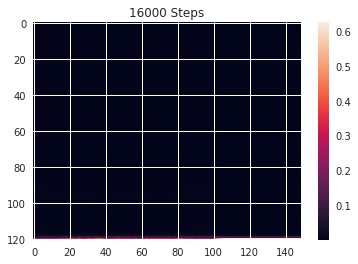

minibatch loop:  78%|███████▊  | 639/818 [20:53<05:51,  1.96s/it]

(160, 160)


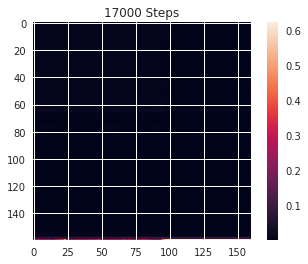

minibatch loop:   0%|          | 3/818 [00:05<26:42,  1.97s/it]

(149, 146)


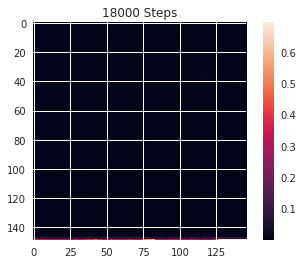

minibatch loop:  23%|██▎       | 185/818 [06:07<20:56,  1.98s/it]

(150, 158)


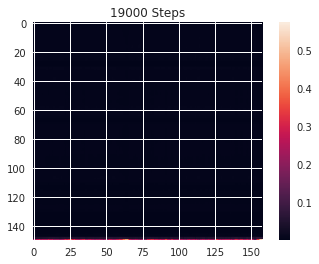

minibatch loop:  45%|████▍     | 367/818 [12:04<14:50,  1.97s/it]

(148, 155)


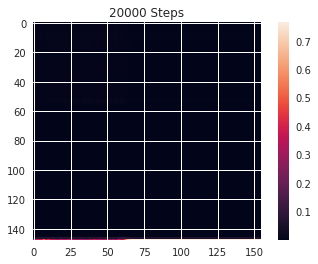

minibatch loop:  67%|██████▋   | 549/818 [17:59<08:48,  1.97s/it]

(154, 155)


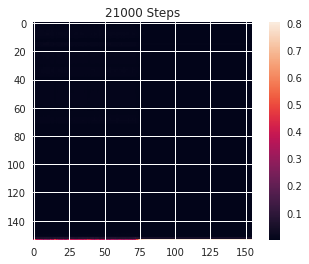

minibatch loop:  89%|████████▉ | 731/818 [24:09<02:52,  1.98s/it]

(154, 152)


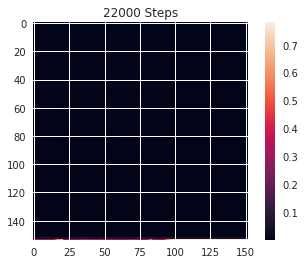

minibatch loop:  12%|█▏        | 95/818 [03:10<24:12,  2.01s/it]

(141, 147)


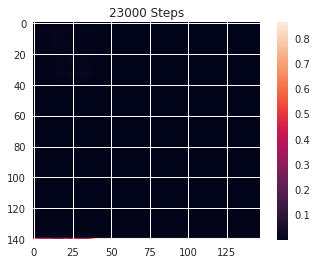

minibatch loop:  34%|███▍      | 277/818 [09:07<17:48,  1.98s/it]

(150, 158)


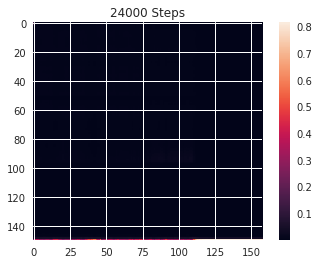

minibatch loop:  62%|██████▏   | 507/818 [16:37<10:12,  1.97s/it]

In [ ]:
from tqdm import tqdm
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Tacotron()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())
batching = (len(paths) // batch_size) * batch_size
EPOCH = 100
for i in range(EPOCH):
    for k in tqdm(range(0, batching, batch_size),desc='minibatch loop'):
        files, max_y, max_z = dynamic_batching(paths[k:k+batch_size])
        max_x = max(lengths[k:k+batch_size])
        batch_x = np.zeros((batch_size, max_x))
        batch_y = np.zeros((batch_size, max_y, n_mels*resampled))
        batch_z = np.zeros((batch_size, max_z, fourier_window_size//2+1))
        for n in range(batch_size):
            batch_x[n, :] = np.pad(texts[k+n],((0,max_x - texts[k+n].shape[0])), mode='constant')
            batch_y[n, :, :] = np.pad(files[n][1], ((0,max_y-files[n][1].shape[0]),(0,0)), mode='constant')
            batch_z[n, :, :] = np.pad(files[n][2], ((0,max_z-files[n][2].shape[0]),(0,0)), mode='constant')
        _, globalstep, cost = sess.run([model.train_op, model.global_step, model.loss],
                                      feed_dict={model.X:batch_x, model.Y:batch_y, model.Z:batch_z})
        if globalstep % 1000 == 0:
            align = sess.run(model.alignments, feed_dict={model.X:batch_x, model.Y:batch_y})
            plot_alignment(align[0,:,:], globalstep)
            saver.save(sess, "%s/checkp/model-%d.ckpt"%(os.getcwd(), globalstep))